In [1]:
#%matplotlib widget

In [1]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']
#['#D9008E','#0000D2','#8400D6','#0048D1','#00C6CF','#21E121','#B5F23C','#3900D4']

In [2]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA,SparsePCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from ephysvibe.task import task_constants
import pca_tools
# import the animation and the HTML module to create and render the animation
from matplotlib import animation 
from IPython.display import HTML
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib
from sklearn.preprocessing import StandardScaler
seed=2024

/tmp/ipykernel_94057/1447183538.py:20: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
matplotlib.rcParams['animation.embed_limit'] = 2**128

### Define functions

In [4]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [5]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz

### Read data

In [6]:
# Load data
n_test=1
min_trials=10
nonmatch=True
time_before=500
start=-200
end_test = n_test*450+200
end=450+400+400+end_test

# Define epochs
part1 = 200+450+400
test1_st = part1+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d1 = np.arange(200+450,part1,2)
idx_d2 = np.arange(part1,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,end-start,2)

In [7]:
# part 1 
t_epochs1 = {'fixation':idx_f,'sample':idx_s,'delay':idx_d1}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors1 = {'epochs':{'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[1]}}
colors_neu1 = {'epochs':{'fixation':greyscale[0],'sample':greyscale[1],'delay':greyscale[1]}}#
# part 2 
t_epochs2 = {'delay':idx_d2,'test1':idx_t1,'test off':idx_aftert}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors2 = {'epochs':{'delay':colors_g[6],'test1':colors_g[6],'test2':colors_g[6],'test3':colors_g[6],'test4':colors_g[6],'test off':colors_g[-1]}}
colors_neu2 = {'epochs':{'delay':greyscale[5],'test1':greyscale[5],'test2':greyscale[5],'test3':greyscale[5],'test4':greyscale[5],'test off':greyscale[7]}}#

In [8]:
if platform.system() == "Linux":
    basepath = (
        "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/"
    )
elif platform.system() == "Windows":
    basepath = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'

save=True
savepath = './'
save_format = 'png'

In [12]:
n_comp=100
pc_areas = {}
for area in ['v4','lip','pfc']:#'lip',
    neurons_fr_read=from_python_hdf5(load_path=basepath+area+'/overlap_in_delay/'+area+'_win50_test'+str(n_test)+'_wnonmatch_min10tr_pca.h5')# include_non_match/  _wnonmatch_min10tr _pos_bottom_right_non0
    neurons_fr = []
    for asc in neurons_fr_read:
        fr = asc["fr"]
        if fr is not None:
            fr_concat = np.concatenate(fr,axis=0)
            neurons_fr.append(fr_concat)
    neurons_fr = np.array(neurons_fr)
    print('%s %d'%(area,neurons_fr.shape[0]))
    # ss = StandardScaler(with_mean=True, with_std=False)
    # neurons_fr = ss.fit_transform(neurons_fr.T).T
    pc_areas[area] = {'n_neurons':neurons_fr}


v4 948
lip 202
pfc 1649


In [10]:
neurons_fr=np.concatenate((  pc_areas[area],  pc_areas[area],  pc_areas[area]),axis=1)

(1649, 10500)

In [22]:
nn/int(np.floor(nn/200))

206.125

In [26]:
ssn=[]
for area in ['v4','lip','pfc']:
    nn=pc_areas[area]['n_neurons'].shape[0]
    ssn.append(np.mean(pc_areas[area]['n_neurons'].reshape(nn,5,end-start)[np.arange(0,nn,int(np.floor(nn/200))),1:],axis=1)[:200])
ssn=np.concatenate(ssn,axis=1)

In [27]:
ssn.shape

(200, 6300)

In [30]:
neurons_fr = ssn#z_score(neurons_fr,with_std=False)
model,pc_s = pca_tools.compute_pca(neurons_fr,n_comp=n_comp)
pc_areas['all'] = {'model':model,'pc':pc_s,'n_neurons':neurons_fr.shape[0]}

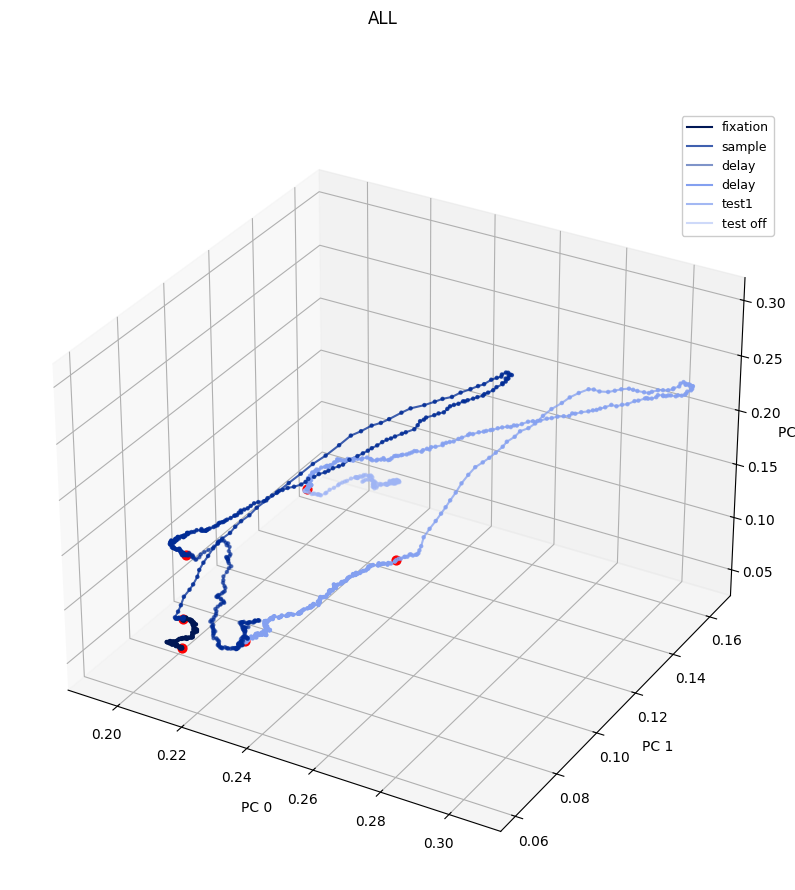

In [33]:
for key in ['all']:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    fig, ax = plt.subplots(figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"})
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    pca_tools.plot_pc_3d(mean_pc_s,colors1,t_epochs1,key,sample_flag = False,fig=fig, ax=ax)
    pca_tools.plot_pc_3d(mean_pc_s,colors2,t_epochs2,key,sample_flag = False,fig=fig, ax=ax)

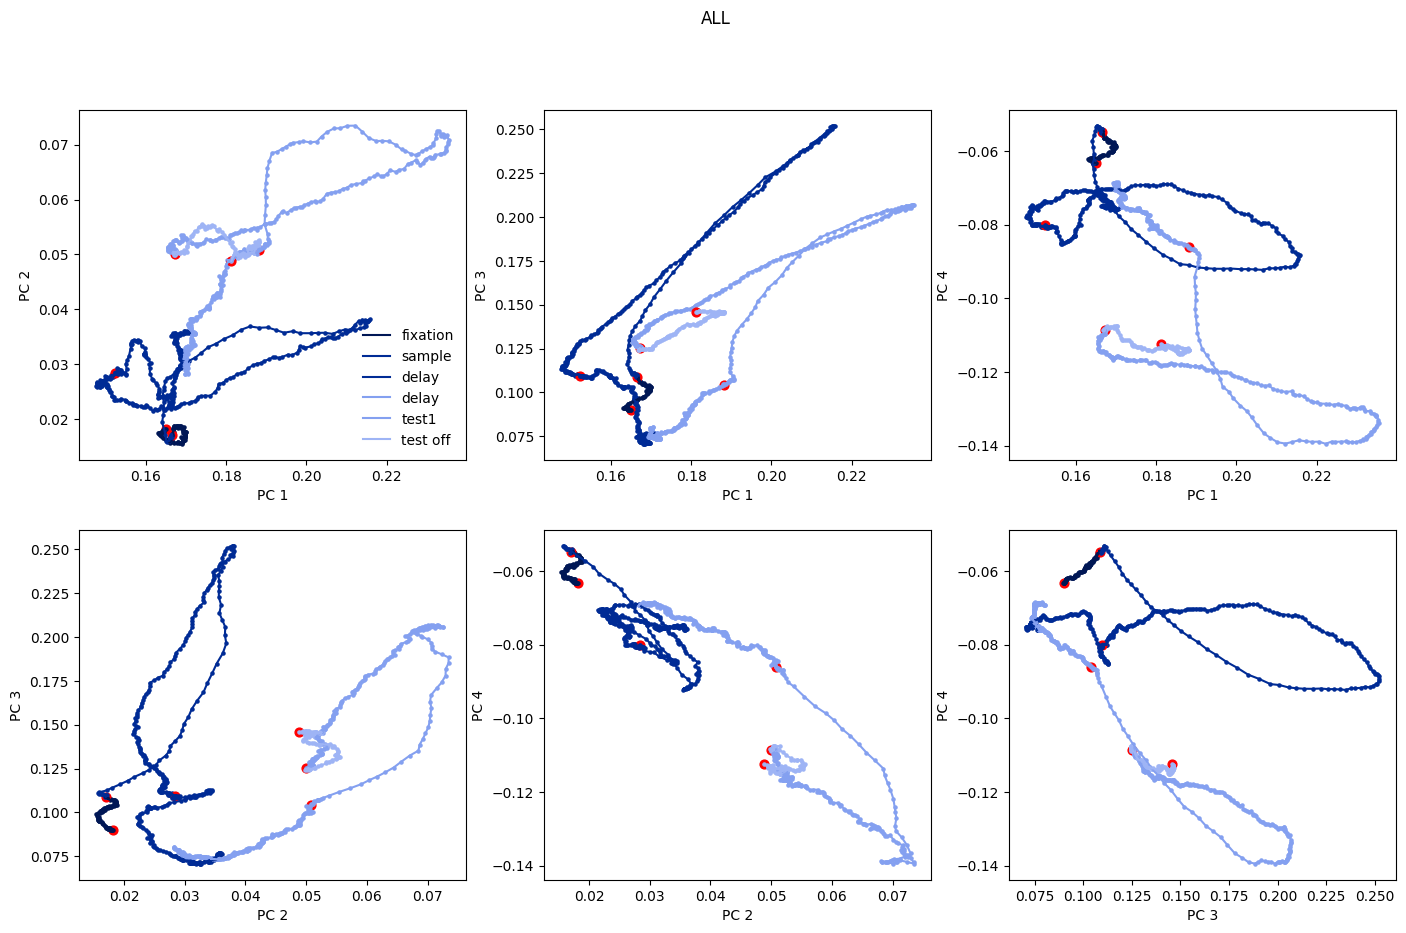

In [35]:
for key in ['all']:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,:,:],axis=1)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    pca_tools.plot_pc(mean_pc_s,colors1,t_epochs1,key,sample_flag = False,fig=fig, ax=ax,idot=0)
    pca_tools.plot_pc(mean_pc_s,colors2,t_epochs2,key,sample_flag = False,fig=fig, ax=ax,idot=-1)
    if save:
        figname = key+'_pcs_sample_mean.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

In [37]:
reshape_pc_s.shape

(100, 3, 2100)

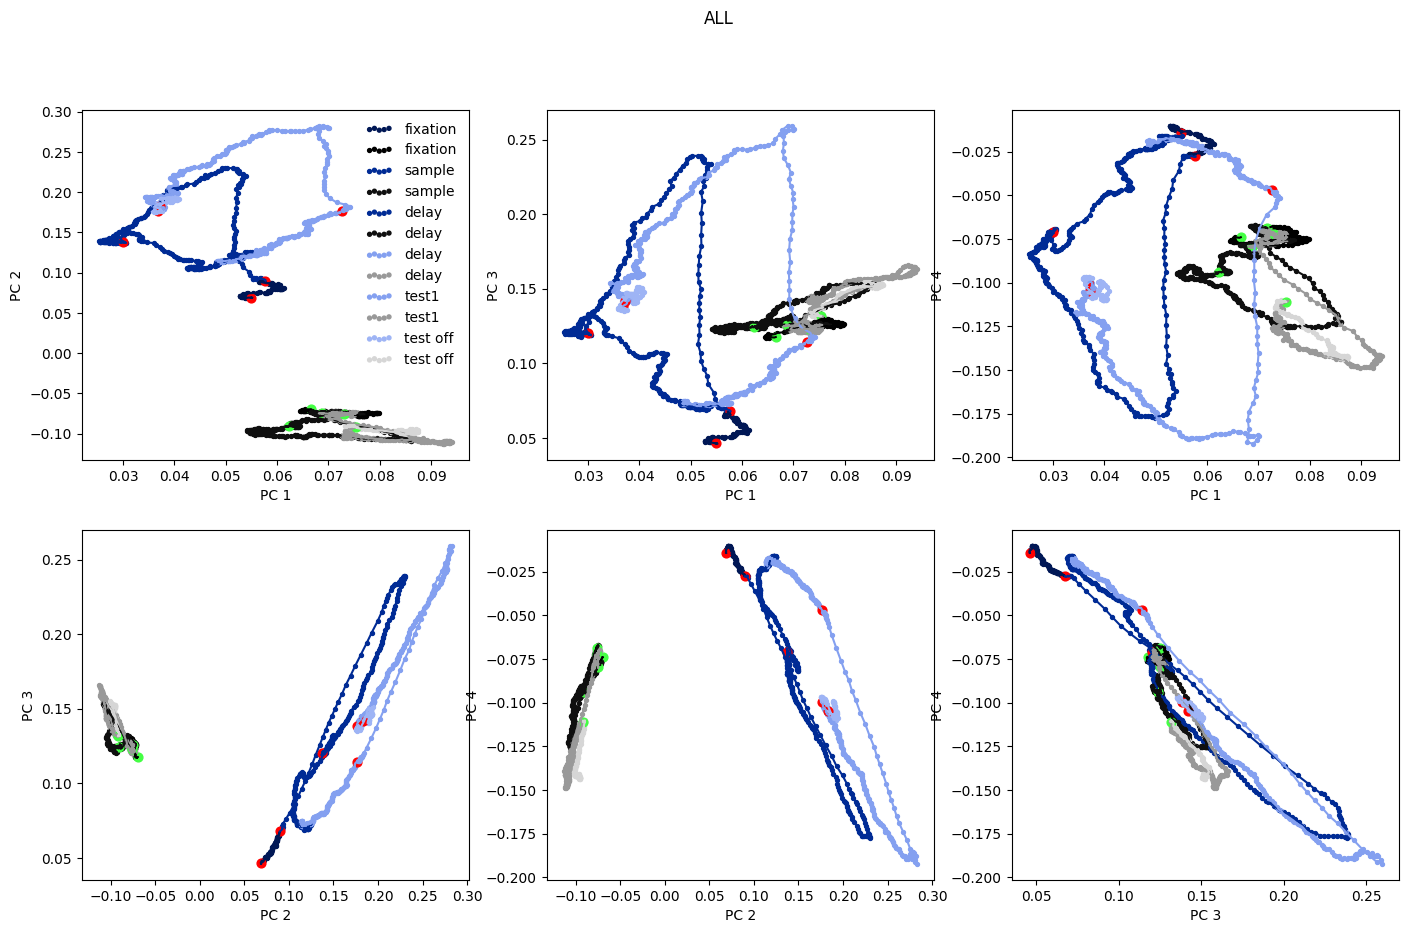

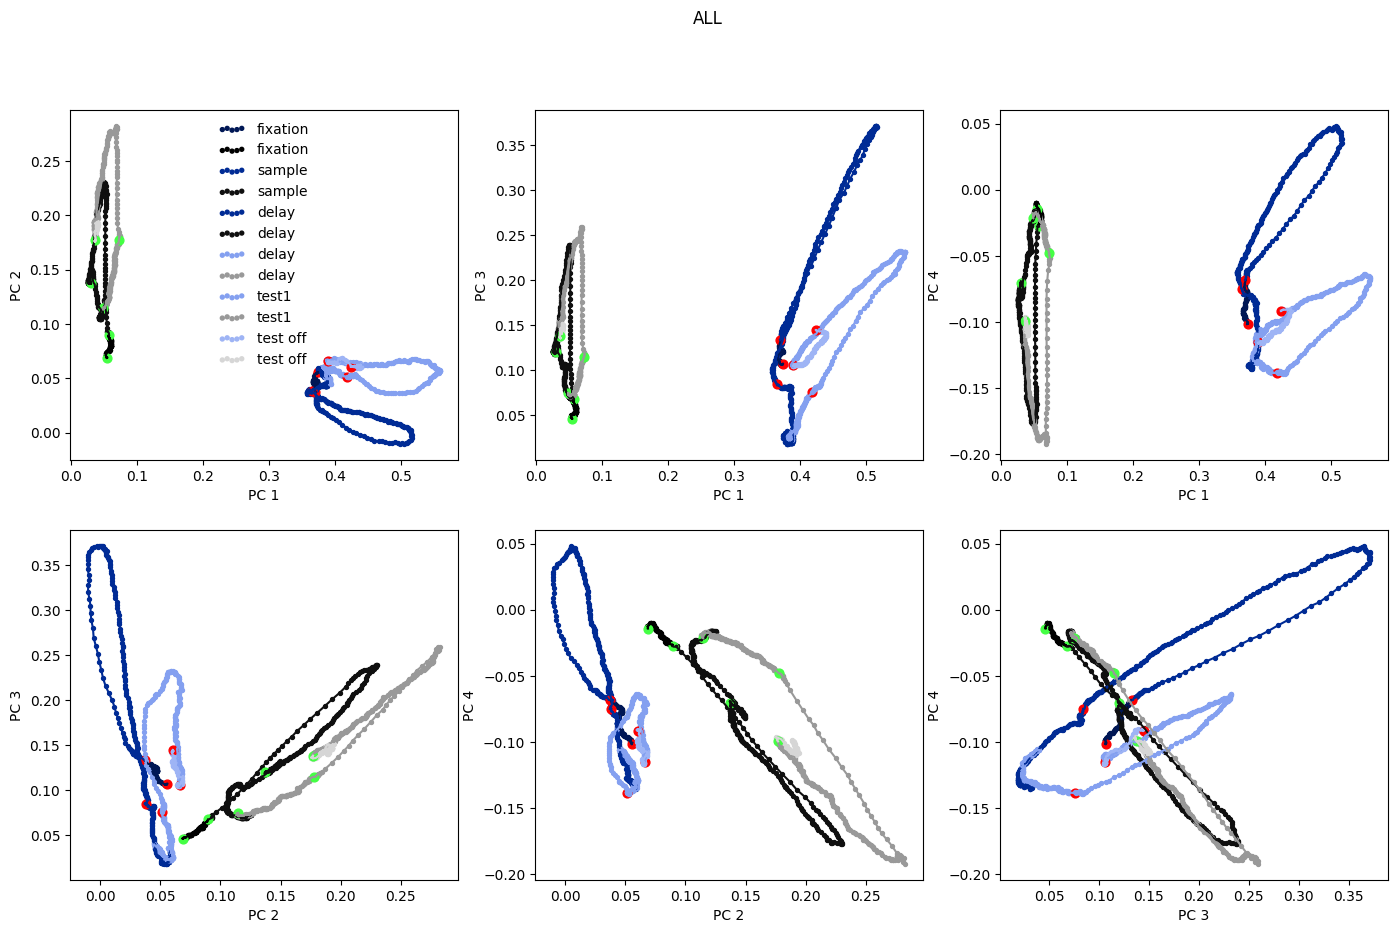

In [41]:
for key in ['all']:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,:,:],axis=1)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    pca_tools.plot_pc_neu(reshape_pc_s[:,1],reshape_pc_s[:,0],colors1,colors_neu1,t_epochs1,key,fig=fig, ax=ax ,idot=0)
    pca_tools.plot_pc_neu(reshape_pc_s[:,1],reshape_pc_s[:,0],colors2,colors_neu2,t_epochs2,key,fig=fig , ax=ax,idot=-1)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    pca_tools.plot_pc_neu(reshape_pc_s[:,2],reshape_pc_s[:,1],colors1,colors_neu1,t_epochs1,key,fig=fig, ax=ax ,idot=0)
    pca_tools.plot_pc_neu(reshape_pc_s[:,2],reshape_pc_s[:,1],colors2,colors_neu2,t_epochs2,key,fig=fig , ax=ax,idot=-1)

    if save:
        figname = key+'_pcs_neutral_sample.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

In [16]:
samples={
    "0": 0,
    "11": 1,
    "15": 2,
    "55": 3,
    "51": 4,
    
}
light_colors = {    "11": "#E45454",  
    "15": "#60B2B2",  
    "51": "#FFA08B",  
    "55": "#7EEBE5",  
    "0": "#BFBFBF",}

In [17]:
colors_s = []
for i_sample in samples.keys():
    colors_s.append({'sample':i_sample,'epochs':{'fixation': task_constants.PALETTE_B1[i_sample],
    'sample': task_constants.PALETTE_B1[i_sample],
    'delay': task_constants.PALETTE_B1[i_sample],
    'test1': task_constants.PALETTE_B1[i_sample],
    'test2': task_constants.PALETTE_B1[i_sample],
    'test3': task_constants.PALETTE_B1[i_sample],
    'test4': task_constants.PALETTE_B1[i_sample],
    'test off': task_constants.PALETTE_B1[i_sample]}})
colors_l = []
for i_sample in samples.keys():
    colors_l.append({'sample':i_sample,'epochs':{'fixation': light_colors[i_sample],
    'sample': light_colors[i_sample],
    'delay': light_colors[i_sample],
    'test1': light_colors[i_sample],
    'test2': light_colors[i_sample],
    'test3': light_colors[i_sample],
    'test4': light_colors[i_sample],
    'test off': light_colors[i_sample]}})



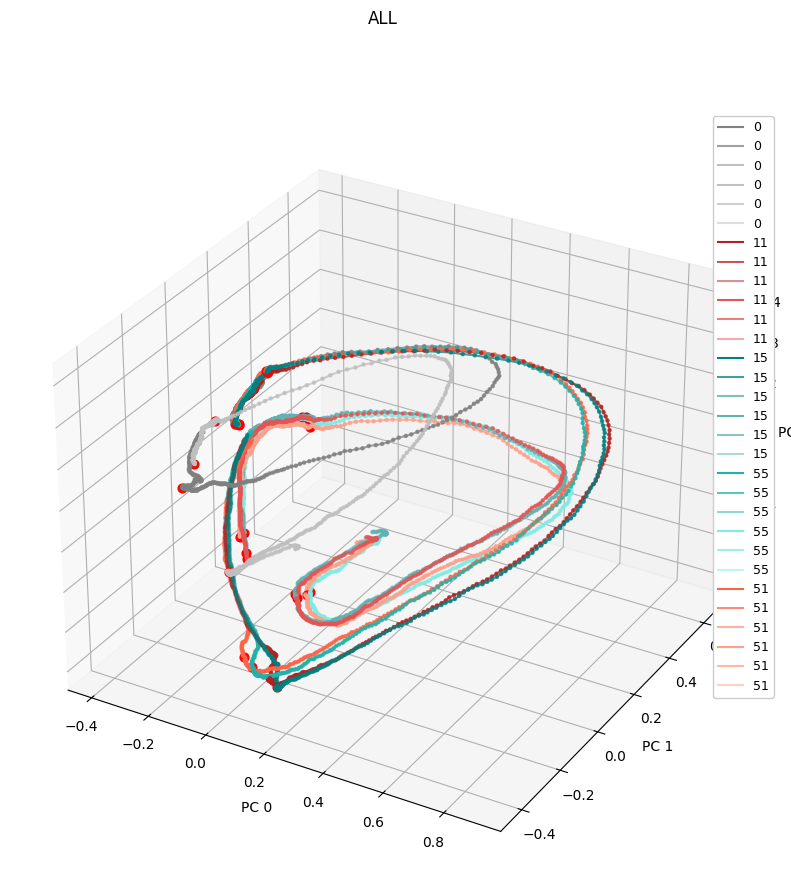

In [18]:
for key in pc_areas:
    reshape_pc_s = pc_areas[key]['pc'].reshape(n_comp,-1,end-start)
    fig, ax = plt.subplots(
        figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for s in range(5):
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_s[s],t_epochs1,key,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
        pca_tools.plot_pc_3d(reshape_pc_s[:,s],colors_l[s],t_epochs2,key,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)

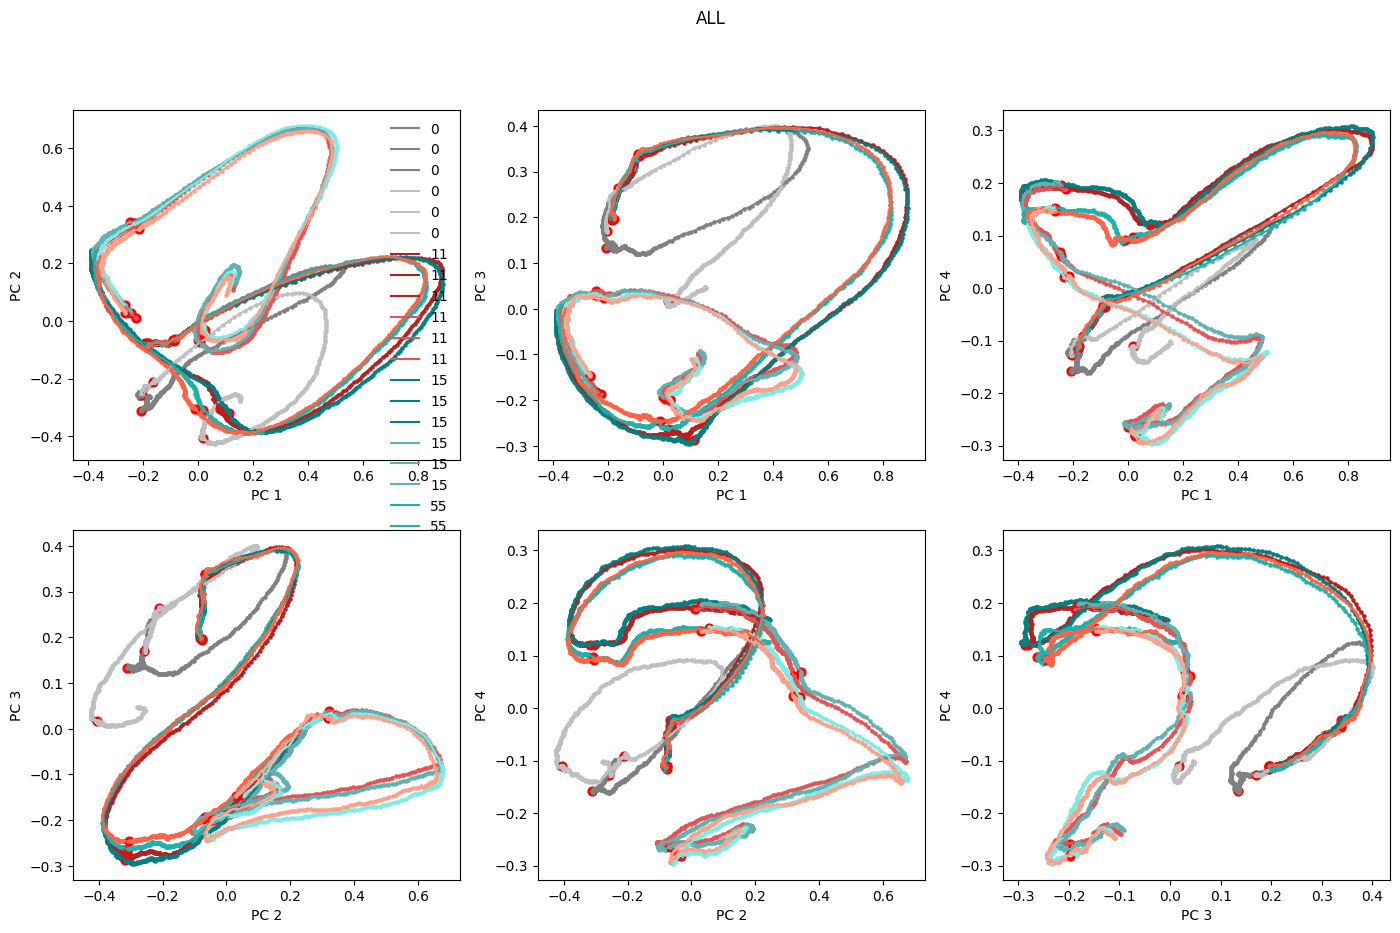

In [19]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,end-start)
    fig, ax = plt.subplots(2, 3, figsize=(17,10))
    for s in range(5):
        pca_tools.plot_pc(reshape_pc_s[:,s],colors_s[s],t_epochs1,area,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
        pca_tools.plot_pc(reshape_pc_s[:,s],colors_l[s],t_epochs2,area,figsize=(17,10),fig=fig,ax=ax,sample_flag = True)
    if save:
        figname = 'pcs_vs_pcs_'+area+'.'+save_format
        fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

all: 6 components to explain 80% of the variance


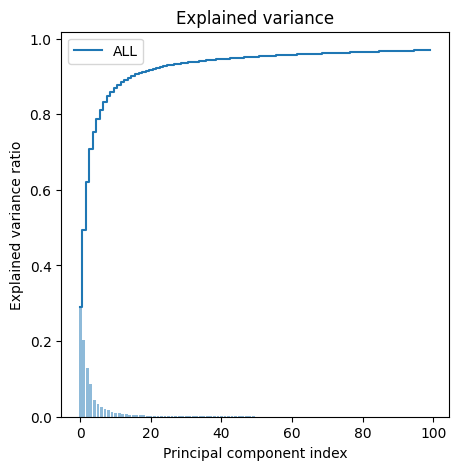

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
for key in pc_areas:
    pca_tools.plot_explained_var(pc_areas[key]['model'],figsize=(5,5),area=key,fig=fig,ax=ax)
if save:
    figname = 'explained_var.'+save_format
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

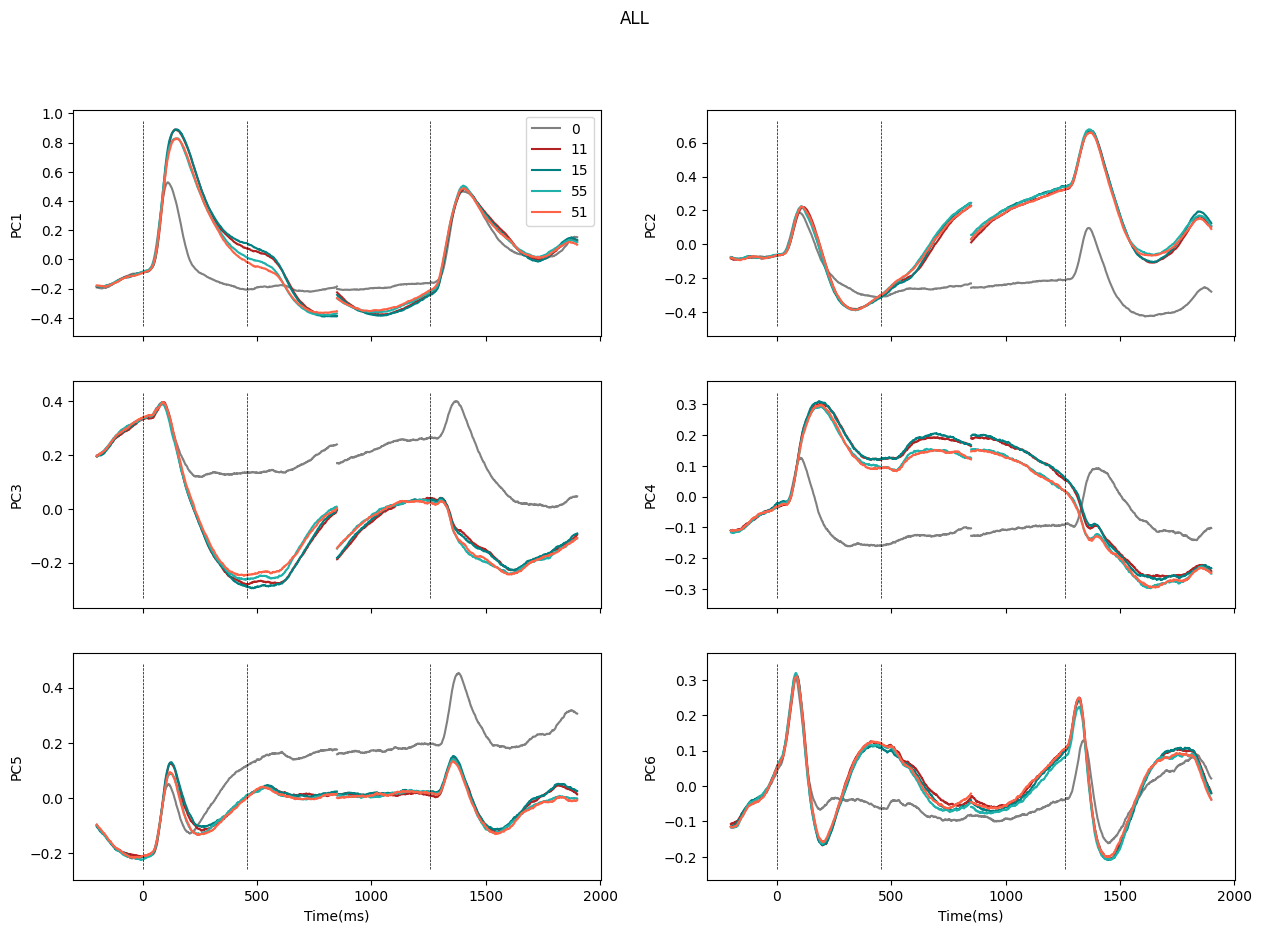

In [21]:
for area in pc_areas:
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,end-start)
    f,ax=plt.subplots(3,2,figsize=(15,10),sharex=True)
    for i_sample in samples.keys():
        
        ax[0,0].plot(range(start,end)[:part1],reshape_pc_s[0,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[0,1].plot(range(start,end)[:part1],reshape_pc_s[1,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[1,0].plot(range(start,end)[:part1],reshape_pc_s[2,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[1,1].plot(range(start,end)[:part1],reshape_pc_s[3,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2,0].plot(range(start,end)[:part1],reshape_pc_s[4,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
        ax[2,1].plot(range(start,end)[:part1],reshape_pc_s[5,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

        ax[0,0].plot(range(start,end)[part1:],reshape_pc_s[0,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[0,1].plot(range(start,end)[part1:],reshape_pc_s[1,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[1,0].plot(range(start,end)[part1:],reshape_pc_s[2,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[1,1].plot(range(start,end)[part1:],reshape_pc_s[3,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[2,0].plot(range(start,end)[part1:],reshape_pc_s[4,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
        ax[2,1].plot(range(start,end)[part1:],reshape_pc_s[5,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])

    ax[0,0].vlines([0,458,1258],ax[0,0].get_ylim()[0],ax[0,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[0,1].vlines([0,458,1258],ax[0,1].get_ylim()[0],ax[0,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[1,0].vlines([0,458,1258],ax[1,0].get_ylim()[0],ax[1,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[1,1].vlines([0,458,1258],ax[1,1].get_ylim()[0],ax[1,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[2,0].vlines([0,458,1258],ax[2,0].get_ylim()[0],ax[2,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
    ax[2,1].vlines([0,458,1258],ax[2,1].get_ylim()[0],ax[2,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)

    ax[0,0].set(ylabel='PC1')
    ax[0,1].set(ylabel='PC2')
    ax[1,0].set(ylabel='PC3')
    ax[1,1].set(ylabel='PC4')
    ax[2,0].set(xlabel='Time(ms)',ylabel='PC5')
    ax[2,1].set(xlabel='Time(ms)',ylabel='PC6')
    ax[0,0].legend()
    f.suptitle(area.upper())
    if save:
        figname = 'pcs_vs_time_'+area+'.'+save_format
        f.savefig(savepath+figname,format=save_format,bbox_inches="tight")

In [22]:
# %matplotlib notebook

### Animation neutral vs non-neutral

In [23]:
for area in pc_areas:

    # apply some smoothing to the trajectories
    sigma = 3 # smoothing amount
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    neutral_pc_s= reshape_pc_s[:,0,:]
    g_mean_pc=mean_pc_s.copy()
    g_neutral_pc=neutral_pc_s.copy()

    for c in range(g_mean_pc.shape[0]):
        g_mean_pc[c, :] =  gaussian_filter1d(g_mean_pc[c, :], sigma=sigma)
        g_neutral_pc[c, :] =  gaussian_filter1d(g_neutral_pc[c, :], sigma=sigma)

    x1 = g_mean_pc[:,:-200].copy()
    x1[:,200+450+400:]=np.nan
    x2 = g_mean_pc[:,200:].copy()
    x2[:,:450+400]=np.nan

    x1_neu = g_neutral_pc[:,:-200].copy()
    x1_neu[:,200+450+400:]=np.nan
    x2_neu = g_neutral_pc[:,200:].copy()
    x2_neu[:,:450+400]=np.nan

    time=np.arange(0,x2.shape[1])-200

    # utility function to clean up and label the axes
    def style_ax(ax,xlabel,ylabel):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(area.upper())
        
    for component_x in np.arange(0, 4):
        for component_y in np.arange(0 + component_x, 4):
            if component_x == component_y:
                continue

            # create the figure
            fig = plt.figure(figsize=[9, 9])
            ax = fig.add_subplot()#1, 1, projection='3d')
            plt.close()

            # annotate with stimulus and time information
            text = ax.text(0.05, 0.95, 'Fixation \nt = %d ms'%(time[0]), fontsize=14,transform=ax.transAxes, va='top')

            def animate(i):
                # pick the components corresponding to the x, y, and z axes

                ax.clear() # clear up trajectories from previous iteration
                xlabel = 'PC '+ str(component_x+1)
                ylabel = 'PC '+ str(component_y+1)
                style_ax(ax,xlabel,ylabel)

                # plot 1st part
                x11 = x1[component_x,0:i]
                y11 = x1[component_y,0:i]           
                ax.plot(x11, y11,'#002B95')
                #  neu
                x11_neu = x1_neu[component_x,0:i]
                y11_neu = x1_neu[component_y,0:i] 
                ax.plot(x11_neu, y11_neu,'#0F0F0F')

                # plot 2nd part
                x22 = x2[component_x,0:i]
                y22 = x2[component_y,0:i]           
                ax.plot(x22, y22,'#4F79E5')
                #  neu
                x22_neu = x2_neu[component_x,0:i]
                y22_neu = x2_neu[component_y,0:i] 
                ax.plot(x22_neu, y22_neu,'#999999')
                xlim = [x1[component_x], x1_neu[component_x], x2[component_x], x2_neu[component_x]]
                ylim = [x1[component_y], x1_neu[component_y], x2[component_y], x2_neu[component_y]]
                ax.set_xlim((np.nanmin(xlim)-0.1, np.nanmax(xlim)+0.1))
                ax.set_ylim((np.nanmin(ylim)-0.1, np.nanmax(ylim)+0.1))
                # update stimulus and time annotation
                if (i < 200):
                    #stimdot.set_data(10, 14)
                    ax.text(0.05, 0.95,'Fixation \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200,i<200+450):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    # neu
                    ax.scatter(x11_neu[200], y11_neu[200],c="#4CBA4C")
                    ax.text(0.05, 0.95,'Sample ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200+450,i<200+450+600):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                    # neu
                    ax.scatter(x11_neu[200], y11_neu[200],c="#4CBA4C")
                    ax.scatter(x11_neu[200+450], y11_neu[200+450],c="#4CBA4C")
                    ax.text(0.05, 0.95,'Delay \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200+450+600,i<200+450+600+450):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                    ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")
                    # neu
                    ax.scatter(x11_neu[200], y11_neu[200],c="#4CBA4C")
                    ax.scatter(x11_neu[200+450], y11_neu[200+450],c="#4CBA4C")
                    ax.scatter(x22_neu[200+450+600], y22_neu[200+450+600],c="#4CBA4C")
                    ax.text(0.05, 0.95,'Test ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                else:
                    #stimdot.set_data([], [])
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                    ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")
                    ax.scatter(x22[200+450+600+450], y22[200+450+600+450],c="#FF0000")
                    # neu
                    ax.scatter(x11_neu[200], y11_neu[200],c="#4CBA4C")
                    ax.scatter(x11_neu[200+450], y11_neu[200+450],c="#4CBA4C")
                    ax.scatter(x22_neu[200+450+600], y22_neu[200+450+600],c="#4CBA4C")
                    ax.scatter(x22_neu[200+450+600+450], y22_neu[200+450+600+450],c="#4CBA4C")
                    ax.text(0.05, 0.95,'Test OFF \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                return []

            neu_anim = animation.FuncAnimation(fig, animate,
                                        frames=range(1,x1.shape[1],2), interval=50, 
                                        blit=True)

            #
            if save:
                figname = area+'_pc'+str(component_x+1)+'_pc'+str(component_y+1)+'_neutral_animation.gif'
                neu_anim.save(figname, writer='Pillow', fps=30)
            else:
                HTML(neu_anim.to_jshtml(default_mode='once'))

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


KeyboardInterrupt: 

### Animation on avg

In [ ]:
for area in pc_areas:

    # apply some smoothing to the trajectories
    sigma = 3 # smoothing amount
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,end-start)
    mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    neutral_pc_s= reshape_pc_s[:,0,:]
    g_mean_pc=mean_pc_s.copy()
    g_neutral_pc=neutral_pc_s.copy()

    for c in range(g_mean_pc.shape[0]):
        g_mean_pc[c, :] =  gaussian_filter1d(g_mean_pc[c, :], sigma=sigma)
        

    x1 = g_mean_pc[:,:-200].copy()
    x1[:,200+450+400:]=np.nan
    x2 = g_mean_pc[:,200:].copy()
    x2[:,:450+400]=np.nan

    time=np.arange(0,x2.shape[1])-200

    # utility function to clean up and label the axes
    def style_ax(ax,xlabel,ylabel):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(area.upper())

    for component_x in np.arange(0, 4):
        for component_y in np.arange(0 + component_x, 4):
            if component_x == component_y:
                continue
            # create the figure
            fig = plt.figure(figsize=[9, 9])
            ax = fig.add_subplot()#1, 1, projection='3d')
            plt.close()

            # annotate with stimulus and time information
            text = ax.text(0.05, 0.95, 'Fixation \nt = %d ms'%(time[0]), fontsize=14,transform=ax.transAxes, va='top')

            def animate(i):
                # pick the components corresponding to the x, y, and z axes
                # component_x = 0
                # component_y = 1
                ax.clear() # clear up trajectories from previous iteration
                xlabel = 'PC '+ str(component_x+1)
                ylabel = 'PC '+ str(component_y+1)
                style_ax(ax,xlabel,ylabel)

                # plot 1st part
                x11 = x1[component_x,0:i]
                y11 = x1[component_y,0:i]           
                ax.plot(x11, y11,'#002B95')

                # plot 2nd part
                x22 = x2[component_x,0:i]
                y22 = x2[component_y,0:i]           
                ax.plot(x22, y22,'#4F79E5')

                xlim = [x1[component_x], x2[component_x]]
                ylim = [x1[component_y], x2[component_y]]
                ax.set_xlim((np.nanmin(xlim)-0.1, np.nanmax(xlim)+0.1))
                ax.set_ylim((np.nanmin(ylim)-0.1, np.nanmax(ylim)+0.1))
                # update stimulus and time annotation
                if (i < 200):
                    #stimdot.set_data(10, 14)
                    ax.text(0.05, 0.95,'Fixation \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200,i<200+450):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")

                    ax.text(0.05, 0.95,'Sample ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200+450,i<200+450+600):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")

                    ax.text(0.05, 0.95,'Delay \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                elif np.logical_and(i > 200+450+600,i<200+450+600+450):
                    #stimdot.set_data(10, 14)
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                    ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")

                    ax.text(0.05, 0.95,'Test ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                else:
                    #stimdot.set_data([], [])
                    ax.scatter(x11[200], y11[200],c="#FF0000")
                    ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                    ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")
                    ax.scatter(x22[200+450+600+450], y22[200+450+600+450],c="#FF0000")

                    ax.text(0.05, 0.95,'Test OFF \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                return []

            anim = animation.FuncAnimation(fig, animate,
                                        frames=range(1,x1.shape[1],2), interval=50, 
                                        blit=True)

            #
            if save:
                figname = area+'_pc'+str(component_x+1)+'_pc'+str(component_y+1)+'_animation.gif'
                anim.save(figname, writer='Pillow', fps=30)
            else:
                HTML(anim.to_jshtml(default_mode='once'))

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


### Animation for different samples

In [ ]:
# light_colors = {    "11": "#E45454",  
#     "15": "#60B2B2",  
#     "51": "#FFA08B",  
#     "55": "#7EEBE5",  
#     "0": "#BFBFBF",}

In [ ]:
for area in pc_areas:

    # apply some smoothing to the trajectories
    sigma = 3 # smoothing amount
    reshape_pc_s = pc_areas[area]['pc'].reshape(n_comp,-1,end-start)
    # mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
    g_mean_pc=reshape_pc_s.copy()

    for c in range(g_mean_pc.shape[0]):
        for i_s in range(g_mean_pc.shape[1]):
            g_mean_pc[c, i_s, :] =  gaussian_filter1d(g_mean_pc[c,i_s, :], sigma=sigma)
        
    # g_mean_pc=g_mean_pc.reshape(n_comp,-1,end-start)

    x1 = g_mean_pc[:,:,:-200].copy()
    x1[:,:,200+450+400:]=np.nan
    x2 = g_mean_pc[:,:,200:].copy()
    x2[:,:,:450+400]=np.nan

    time=np.arange(0,x2.shape[-1])-200

    # utility function to clean up and label the axes
    def style_ax(ax,xlabel,ylabel):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(area.upper())

    for component_x in np.arange(0, 6):
        for component_y in np.arange(0 + component_x, 6):
            if component_x == component_y:
                continue
            # create the figure
            fig = plt.figure(figsize=[9, 9])
            ax = fig.add_subplot()#1, 1, projection='3d')
            plt.close()

            # annotate with stimulus and time information
            text = ax.text(0.05, 0.95, 'Fixation \nt = %d ms'%(time[0]), fontsize=14,transform=ax.transAxes, va='top')

            def animate(i):
                # pick the components corresponding to the x, y, and z axes
                # component_x = 0
                # component_y = 1
                ax.clear() # clear up trajectories from previous iteration
                xlabel = 'PC '+ str(component_x+1)
                ylabel = 'PC '+ str(component_y+1)
                style_ax(ax,xlabel,ylabel)

                for key,i_s in samples.items():
                    color = task_constants.PALETTE_B1[key]
                    lcolor = light_colors[key]
                    # plot 1st part
                    x11 = x1[component_x,i_s,0:i]
                    y11 = x1[component_y,i_s,0:i]           
                    ax.plot(x11, y11,color)

                    # plot 2nd part
                    x22 = x2[component_x,i_s,0:i]
                    y22 = x2[component_y,i_s,0:i]           
                    ax.plot(x22, y22,lcolor)

                    xlim = [x1[component_x], x2[component_x]]
                    ylim = [x1[component_y], x2[component_y]]
                    ax.set_xlim((np.nanmin(xlim)-0.1, np.nanmax(xlim)+0.1))
                    ax.set_ylim((np.nanmin(ylim)-0.1, np.nanmax(ylim)+0.1))
                    # update stimulus and time annotation
                    if (i < 200):
                        #stimdot.set_data(10, 14)
                        if i_s == 0:
                            ax.text(0.05, 0.95,'Fixation \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                    elif np.logical_and(i > 200,i<200+450):
                        #stimdot.set_data(10, 14)
                        ax.scatter(x11[200], y11[200],c="#FF0000")
                        if i_s == 0:
                            ax.text(0.05, 0.95,'Sample ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                    elif np.logical_and(i > 200+450,i<200+450+600):
                        #stimdot.set_data(10, 14)
                        ax.scatter(x11[200], y11[200],c="#FF0000")
                        ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                        if i_s == 0:
                            ax.text(0.05, 0.95,'Delay \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                    elif np.logical_and(i > 200+450+600,i<200+450+600+450):
                        #stimdot.set_data(10, 14)
                        ax.scatter(x11[200], y11[200],c="#FF0000")
                        ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                        ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")
                        if i_s == 0:
                            ax.text(0.05, 0.95,'Test ON \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                    else:
                        #stimdot.set_data([], [])
                        ax.scatter(x11[200], y11[200],c="#FF0000")
                        ax.scatter(x11[200+450], y11[200+450],c="#FF0000")
                        ax.scatter(x22[200+450+600], y22[200+450+600],c="#FF0000")
                        ax.scatter(x22[200+450+600+450], y22[200+450+600+450],c="#FF0000")
                        if i_s == 0:
                            ax.text(0.05, 0.95,'Test OFF \nt = %d ms'%(time[i]), fontsize=14,transform=ax.transAxes, va='top')
                return []

            anim = animation.FuncAnimation(fig, animate,
                                        frames=range(1,x1.shape[-1],2), interval=50, 
                                        blit=True)

            #
            if save:
                figname = area+'_pc'+str(component_x+1)+'_pc'+str(component_y+1)+'_samples_animation.gif'
                anim.save(figname, writer='Pillow', fps=30)
            else:
                HTML(anim.to_jshtml(default_mode='once'))

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailab